In [4]:
%matplotlib inline

# DEMO - Dowload Satellite-Temperature, use it to force model

This demo requires that you download, from Brightspace, the following files and place them in your working directory:

* model_Mussel_IbarraEtal2014.py
* read_satellites.py
* model_Mussel_IbarraEtal2014_SSTforcing.py

----------------------------

From last week, do you remember the "Mussel" model?

Model run: DONE!!!


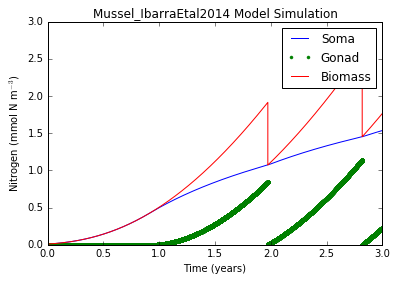

In [2]:
import model_Mussel_IbarraEtal2014 as MusselModel

days, dt, par, InitCond = MusselModel.load_defaults()
output = MusselModel.run_model(days,dt,InitCond,par)
MusselModel.plot_model(output)

The Objectives of this DEMO are:

* Download temperature data from Satellites
* Use it to create a time-series of temperature for a particular location
* Use the time-series of temperature to "force" the mussel model, and impose the effect of time-varying temperature on Mussel growth

------------------

The following snipet of code downloads the monthly-averaged Sea Surface Temperature calculated from the POES, AVHRR and GAC Satellites... and make a plot of the downloaded data. 

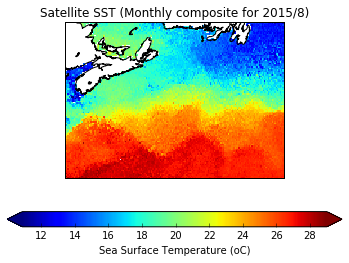

In [5]:
import read_satellites as rs

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -67
maxlon = -50
isub = 0.5

# This one line of code does the whole thing (Download + Plot)
lon, lat, sst = rs.read_frame(year,month,minlat,maxlat,minlon,maxlon,isub)

There! Average SST for August 2016. You not only get the plot, but you also get the actual data. Check out `sst`

In [4]:
sst

masked_array(data =
 [[28.5 26.924999237060547 28.174999237060547 ..., 26.94285774230957
  26.628572463989258 26.531248092651367]
 [28.299999237060547 -- 27.095001220703125 ..., 27.00714111328125
  26.99285888671875 26.881248474121094]
 [28.0 26.600000381469727 27.389999389648438 ..., 26.640907287597656
  26.742307662963867 26.875]
 ..., 
 [-- -- -- ..., 13.336112022399902 14.160000801086426 13.069999694824219]
 [-- -- -- ..., 13.300000190734863 12.087499618530273 13.208333015441895]
 [-- -- -- ..., 13.09999942779541 13.158333778381348 13.125]],
             mask =
 [[False False False ..., False False False]
 [False  True False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]],
       fill_value = -1e+07)

Lets do some playing around...

Lets plot the average temperature in February 2015

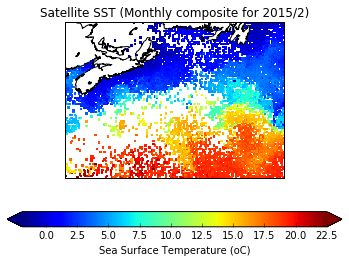

In [5]:
month = 2
lon, lat, sst = rs.read_frame(year,month,minlat,maxlat,minlon,maxlon,isub)

You can see that the water is colder in February (compared to the plot of August above), but also there are missing data because of more cloud cover in February.

------------------------------

Lets query a larger region:

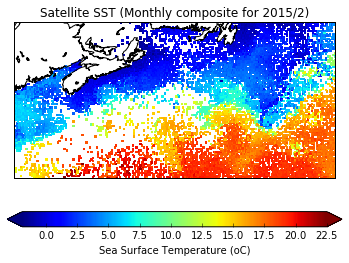

In [6]:
minlon = -70
maxlon = -45
lon, lat, sst = rs.read_frame(year,month,minlat,maxlat,minlon,maxlon,isub)

Noe lets use the `rs.read_timeSeries` function, which download all the monthly average for ONE single spot over a specified period. If no period is specified, the default is between 2010-01-01 and 2015-05-31

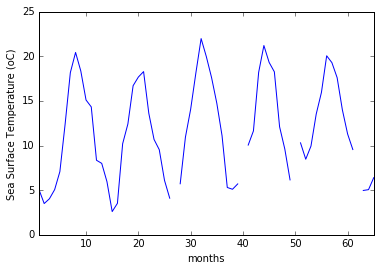

In [7]:
import read_satellites as rs
lat = 43
lon = -62
sst = rs.read_timeSeries(lat,lon)

As you can see, you get the time-series of Sea Surface Temperature from the queried lat/lon. You get the plot plus the data. Note that there are some "empty spot" where there where clouds.

------------

Now lets import a modified "Mussel model" that accepts `sst` as an input, and uses it to force the model (before Temperature was constant throughout the entire model run).

Lets see how the New "Mussel model" with forcing works:

LOADED Satellite SST!
Model run: DONE!!!


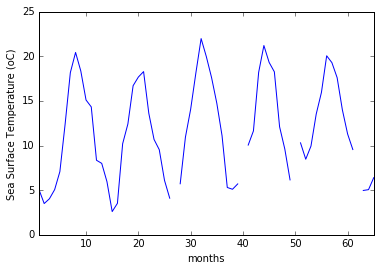

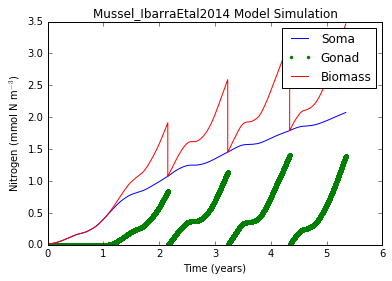

In [8]:
import model_Mussel_IbarraEtal2014_SSTforcing as MusselModel_SST

days, dt, par, InitCond =  MusselModel_SST.load_defaults()
days, sst = MusselModel_SST.read_satellite_sst(dt,lat=43,lon=-62)
output =  MusselModel_SST.run_model(days,dt,InitCond,par,sst)
MusselModel_SST.plot_model(output)

Just to compare, lets run the "old" Mussel model:

Model run: DONE!!!


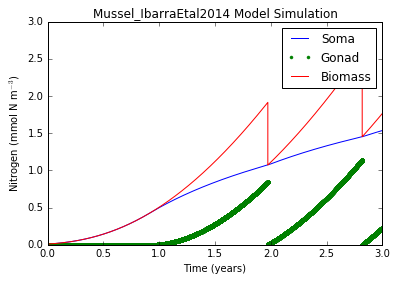

In [9]:
import model_Mussel_IbarraEtal2014 as MusselModel

days, dt, par, InitCond = MusselModel.load_defaults()
output = MusselModel.run_model(days,dt,InitCond,par)
MusselModel.plot_model(output)

The difference is substantial, growth slows down during the cold parts of the year!

If you compare `model_Mussel_IbarraEtal2014.py` against `model_Mussel_IbarraEtal2014_SSTforcing.py`... There are only 3 minor changes:

(1) Indicate `sst` as input

Line 65 BEFORE: def run_model(days,dt,InitCond,par):

 Line 65 AFTER: def run_model(days,dt,InitCond,par,sst):

(2) Initialize `Temp` with `sst`

Line 107 BEFORE: Temp = InitCond['Temp']

 Line 107 AFTER: Temp = sst

(3) Make `Temp` as function of time: `Temp[t]`

Line 122 and 122 BEFORE:
```
        L_Temp[t] = min(max(0.,1.-np.exp(-par['KTempL']*(Temp-par['TempL']))), \
                     max(0.,1.+((1.-np.exp(par['KTempH']*Temp))/(np.exp(par['KTempH']*par['TempH'])-1.))))
```

Line 122 and 122 AFTER:
```
        L_Temp[t] = min(max(0.,1.-np.exp(-par['KTempL']*(Temp[t]-par['TempL']))), \
                     max(0.,1.+((1.-np.exp(par['KTempH']*Temp[t]))/(np.exp(par['KTempH']*par['TempH'])-1.))))
```